In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# %matplotlib nbagg
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import rcParams  # Para aumentar la resolución de los gráficos de Matplot
import seaborn as sns
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams["font.size"] = 14
rcParams['figure.figsize'] = (12, 6)
rcParams['figure.dpi'] = 100
plt.style.use('seaborn-dark-palette')

In [2]:
def rankine(x,omega,c): # Hay que chequearla porque no se si funciona bien
    f = []
    for i in x:
        if i < c:
            f.append(omega*i)
        else:
            f.append((omega*c**2)/i)
    return np.array(f)

def rankine2(x,omega,c):
    return np.piecewise(x,[x<c, x>=c], [lambda x: omega*x, lambda x: (omega*c**2)/x])

def burgers(x,a,b):
  return a*(1-np.exp(-(x/b)**2))/x

In [50]:
def promediar(r, v_theta, r_err, v_theta_err, rango=0.07):
    
    ordenamiento = sorted(zip(r,v_theta, r_err, v_theta_err)) # Con esto estamos ordenando las listas de menor a mayor segun el radio, manteniendo la velocidad tangencial de cada valor de r
    r_ord = [i[0] for i in ordenamiento]
    v_t_ord = [i[1] for i in ordenamiento]
    r_ord_err = [i[2] for i in ordenamiento]
    v_t_ord_err = [i[3] for i in ordenamiento]
    
    r_promedio = [] # Definimos las listas donde guardaremos los promedios
    r_promedio_err = []
    v_t_promedio = []
    v_t_promedio_err = []

    i = 0 # Definimos los iteradores
    j = 0

    while i < len(r_ord): # Empezamos un loop
        l_r_prom = [] # Creamos listas para hacer el promedio entre los valores que esten dentro del rango
        l_v_t_prom = []
        l_r_err = []
        l_v_t_err = []
        while j < len(r_ord) and r_ord[j] <= r_ord[i] + rango: # Recorremos mientras el j no supere la longitud de r_ord y mientras el r j-esimo sea menor al r i-esimo mas el rango
            # En ese caso, metemos los valores j-esimos en las listas
            l_r_prom.append(r_ord[j])
            l_r_err.append(r_ord_err[j])
            l_v_t_prom.append(v_t_ord[j])
            l_v_t_err.append(v_t_ord_err[j])
            j += 1
        if len(l_r_prom) != 0: # Pedimos que las longitudes de las listas sean distinto de cero ya que sino la suma no funciona
            # Realizamos el promedio de los valores que cumplen el rango
            r_promedio.append(sum(l_r_prom)/len(l_r_prom)) 
            v_t_promedio.append(sum(l_v_t_prom)/len(l_v_t_prom))
            r_promedio_err.append(sum(l_r_err)/np.sqrt(len(l_r_err)))
            v_t_promedio_err.append(sum(l_v_t_err)/np.sqrt(len(l_v_t_err)))
        i = j # Ahora como ya recorrimos varios valores con j y no queremos volver a repetirlos, definimos que i arranque desde el ultimo j
    
    r_promedio, v_t_promedio, r_promedio_err, v_t_promedio_err = np.array(r_promedio), np.array(v_t_promedio), np.array(r_promedio_err), np.array(v_t_promedio_err)

    return r_promedio, v_t_promedio, r_promedio_err, v_t_promedio_err

In [121]:
def ajuste(f_ajuste, r, v, r_err, v_theta_err, fit_lims, ax, mostrar_parametros=True):
    cond = (r>fit_lims[0])&(r<fit_lims[1])
    popt, pcov = curve_fit(f_ajuste, r[cond], v[cond], bounds=([-np.inf, 0], [np.inf, np.inf]), 
                           #sigma=v_theta_err, absolute_sigma=True
                           )
    a, b = popt
    err_a, err_b = np.sqrt(np.diag(pcov))
    
    # Declaramos nuestro nuevo dominio e imagen y graficamos el ajuste
    r_dense = np.linspace(min(r), max(r), 10000)
    v_dense = f_ajuste(r_dense, a, b)
    
    # Graficamos los datos y el ajuste
    ax.errorbar(r, v, xerr=r_err, yerr=v_theta_err, fmt='k.', label = '$v_{\Theta}(r)$')
    ax.plot(r_dense, v_dense, 'm-', label='Ajuste')
    # Título y labels
    ax.set_xlabel("Radio (cm)")
    ax.set_ylabel("Velocidad (cm/s)")
    ax.grid(True)
    ax.legend()
    # plt.savefig('Ajuste promedio.png')
    # plt.show()

    # Ahora defino omega y c (radio del vortice) segun el ajuste utilizado
    if mostrar_parametros:
        if f_ajuste == burgers:
            omega = a/(b**2)
            c = b
            err_omega = np.sqrt((err_a/(b**2))**2+(2*err_b*a/(b**3))**2)
            err_c = err_b

        if f_ajuste == rankine or f_ajuste == rankine2:
            omega = a
            c = b
            err_omega = err_a
            err_c = err_b

        print(f"La velocidad angular Omega es {round(omega,3)} con error {round(err_omega,3)}")
        print(f"El radio del vortice c es {round(c,3)} con error {round(err_c,4)}")
    
    return omega, err_omega, c, err_c, popt

In [128]:
def find_center(path: str, r_max, fit_lims: list, x_lims: list = "min-max x", y_lims: list = "min-max y", 
                v_quantile = 0.6, interval = 0.07):

    f = np.load(path)

    # Definimos las coordenadas y las velocidades
    x = f['x'].reshape(f['x'].shape[0]*f['x'].shape[1]) #Field[0][:,0]
    y = f['y'].reshape(f['y'].shape[0]*f['y'].shape[1]) #Field[0][:,1]
    u = f['U'].reshape(f['U'].shape[0]*f['U'].shape[1]) #Field[0][:,2]
    v = f['V'].reshape(f['V'].shape[0]*f['V'].shape[1]) #Field[0][:,3]
    err_u = f['Uerr'].reshape(f['Uerr'].shape[0]*f['Uerr'].shape[1])
    err_v = f['Verr'].reshape(f['Verr'].shape[0]*f['Verr'].shape[1])
    
    # #grafico los errores:
    # sns.heatmap(err_u.reshape(69,68), vmax=1)
    # plt.show()
    # sns.heatmap(err_v.reshape(69,68), vmax=1)
    # plt.show()

    # err_v *= 10
    # err_u *= 10

    # recorte de la imagen:
    if x_lims == "min-max x":
        min_x, max_x = 0, np.max(x)
    else: 
        min_x, max_x = x_lims
    if y_lims == "min-max y":
        min_y, max_y = 0, np.max(y)
    else: min_y, max_y = y_lims


    idx_recorte = np.array([i for i in range(len(x)) if 
                            (x[i]>min_x and x[i]<max_x) and 
                            (y[i]>min_y and y[i]<max_y)])
    x = x[idx_recorte]
    y = y[idx_recorte]
    u = u[idx_recorte]
    v = v[idx_recorte]
    err_u = err_u[idx_recorte]
    err_v = err_v[idx_recorte]

    color = np.hypot(u, v)
    color=(color-min(color))/(max(color)-min(color))
    C=plt.cm.Blues(color)

    # # Hacemos un gráfico para visualizar el campo de velocidades
    # fig, axs = plt.subplots(2,2, figsize=(10,10))
    fig = plt.figure(figsize=(plt.figaspect(0.5)))
    ax1 = fig.add_subplot(1, 2, 1)
    Q = ax1.quiver(x,y,u,v, color=C)

    # Seleccionamos los puntos que utilizaremos para calcular el centro (filtramos con un mínimo de velocidad):

    v_threshold = np.quantile(u**2 + v**2, v_quantile)

    idx = np.array([i for i in range(len(x)) if (u[i]**2 + v[i]**2) > v_threshold])
    x_sel = x[idx]
    y_sel = y[idx]
    u_sel = u[idx]
    v_sel = v[idx]
    ax1.scatter(x_sel, y_sel, c='r', s=.5, label="vectores tomados")


    theta = np.arctan(v_sel/u_sel) # ángulos que forma el vector velocidad con la horizontal

    # calculo las rectas de cada punto que contienen al vector posición medido desde el centro:
    m = np.tan(theta-np.pi/2) # pendientes
    b = y_sel - m*x_sel # ordenadas al origen

    # F = [] # acá almacenaremos todas las rectas
    # for i in range(len(x_sel)):
    #     f = lambda X: m[i]*X + b[i] # ecuación de la recta de un solo punto
    #     F.append(f)

    # Buscamos los puntos de intersección entre todas las rectas:

    # dónde guardaremos las coordenadas de los puntos de intersección:
    X_intercept = []
    Y_intercept = []
    for i in range(len(x_sel)):
        m1 = m[i]
        b1 = b[i]
        for j in range(i+1,len(x_sel)):
            m2 = m[j]
            b2 = b[j]
            x_intercept = (b2-b1)/(m1-m2)
            y_intercept = x_intercept*m1 + b1
            X_intercept.append(x_intercept)
            Y_intercept.append(y_intercept)


    bins = 40

    # fig = plt.figure()
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    hist, xedges, yedges = np.histogram2d(X_intercept, Y_intercept, bins=bins, range=[[min_x,max_x],[min_y,max_y]])

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.4/bins, yedges[:-1] + 0.4/bins, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = ((max_x - min_x)/(bins+1)) * np.ones_like(zpos)
    dy = ((max_y - min_y)/(bins+1)) * np.ones_like(zpos)
    dz = hist.ravel()

    ax2.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color='red')

    ### calculo el centro, y lo aniado al primer garfico
    
    ### Quito outliers
    X_intercept = np.array(X_intercept); Y_intercept = np.array(Y_intercept)
    X_intercept = X_intercept[(X_intercept>0) & (X_intercept<20)]
    Y_intercept = Y_intercept[(Y_intercept>0) & (Y_intercept<20)]

    X_centro = np.mean(X_intercept); Y_centro = np.mean(Y_intercept)
    err_x_centro = np.std(X_intercept)/np.sqrt(len(X_intercept))
    err_y_centro = np.std(Y_intercept)/np.sqrt(len(X_intercept))

    ax1.quiver(x,y,u,v, color=C)
    ax1.scatter(X_centro, Y_centro, c='green', marker="x", label="centro")

    ax1.legend()
    plt.show()

    x_corrido =x - X_centro
    y_corrido = y - Y_centro

    r = np.abs(x_corrido+1j*y_corrido)
    theta = np.angle(x_corrido+1j*y_corrido)
    v_r= (x_corrido*u+y_corrido*v)/r
    v_theta = (x_corrido*v-y_corrido*u)/(r)

    err_r = np.sqrt((err_x_centro*x_corrido/r)**2+(err_y_centro*y_corrido/r)**2)
    err_v_theta = np.sqrt((err_x_centro*((v*y_corrido**2-x_corrido*y_corrido*u) / (r**(3/2))))**2 + 
                          (err_y_centro*((u*x_corrido**2-y_corrido*x_corrido*v) / (r**(3/2))))**2 +
                          (err_v*x_corrido/r)**2+(err_u*y_corrido/r)**2
                          )

    err_r, err_v_theta = err_r[r<r_max], err_v_theta[r<r_max]
    v_theta = v_theta[r<r_max]
    r = r[r<r_max]
    
    f_ajuste_list = [burgers, rankine2]

    r_avg, v_theta_avg, r_avg_err, v_theta_avg_err = promediar(r,v_theta, r_err=err_r, v_theta_err=err_v_theta, rango=interval)

    fig, axs = plt.subplots(2, 2)

    for i, f_ajuste in enumerate(f_ajuste_list):
        omega, err_omega, c, err_c, popt = ajuste(f_ajuste, r_avg, v_theta_avg, r_avg_err, v_theta_avg_err, fit_lims, ax=axs[1,i])
    for i, f_ajuste in enumerate(f_ajuste_list):
        omega, err_omega, c, err_c, popt = ajuste(f_ajuste, r, v_theta, err_r, err_v_theta, fit_lims, ax=axs[0,i])
    # axs[0,0].set_suptitle("hola")
    plt.show()

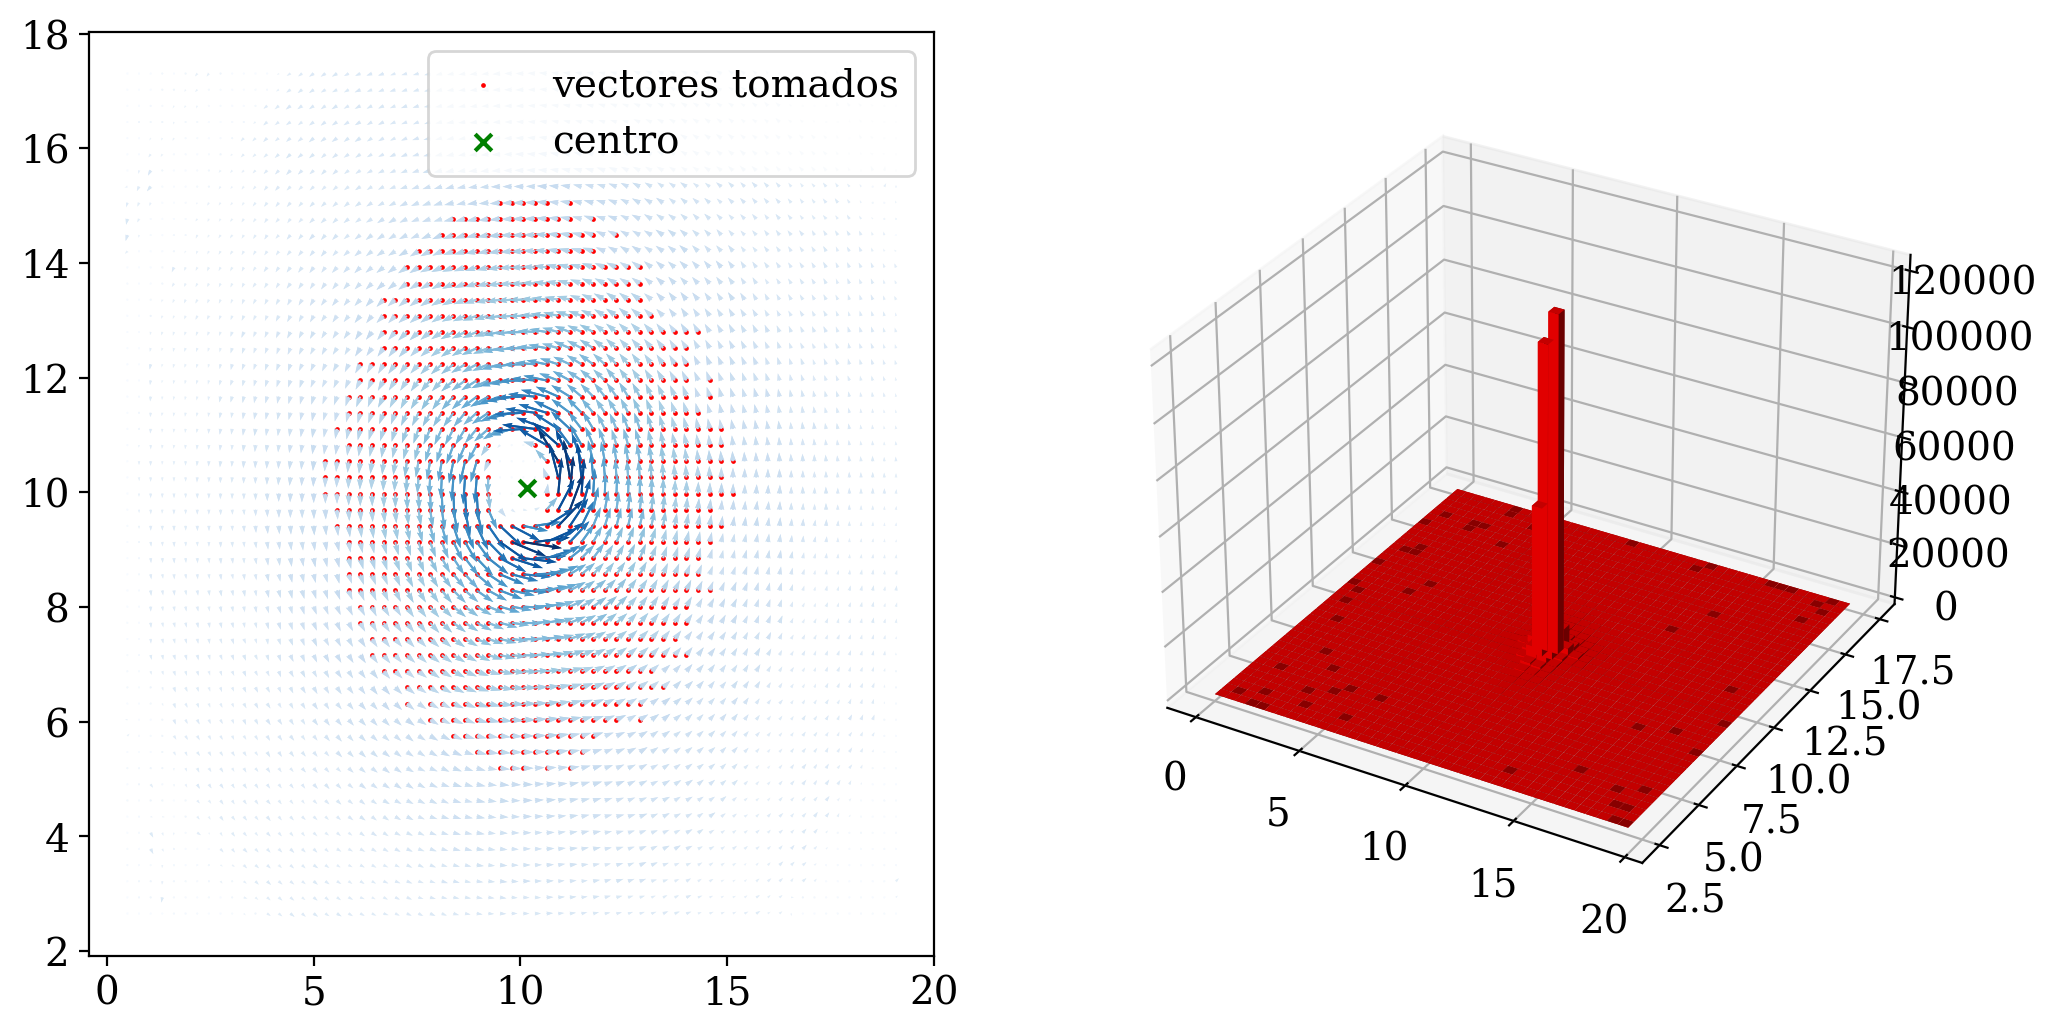

La velocidad angular Omega es 10.104 con error 0.891
El radio del vortice c es 1.219 con error 0.0497
La velocidad angular Omega es 7.922 con error 0.301
El radio del vortice c es 1.311 con error 0.029
La velocidad angular Omega es 11.183 con error 0.214
El radio del vortice c es 1.148 con error 0.0106
La velocidad angular Omega es 7.926 con error 0.088
El radio del vortice c es 1.334 con error 0.008


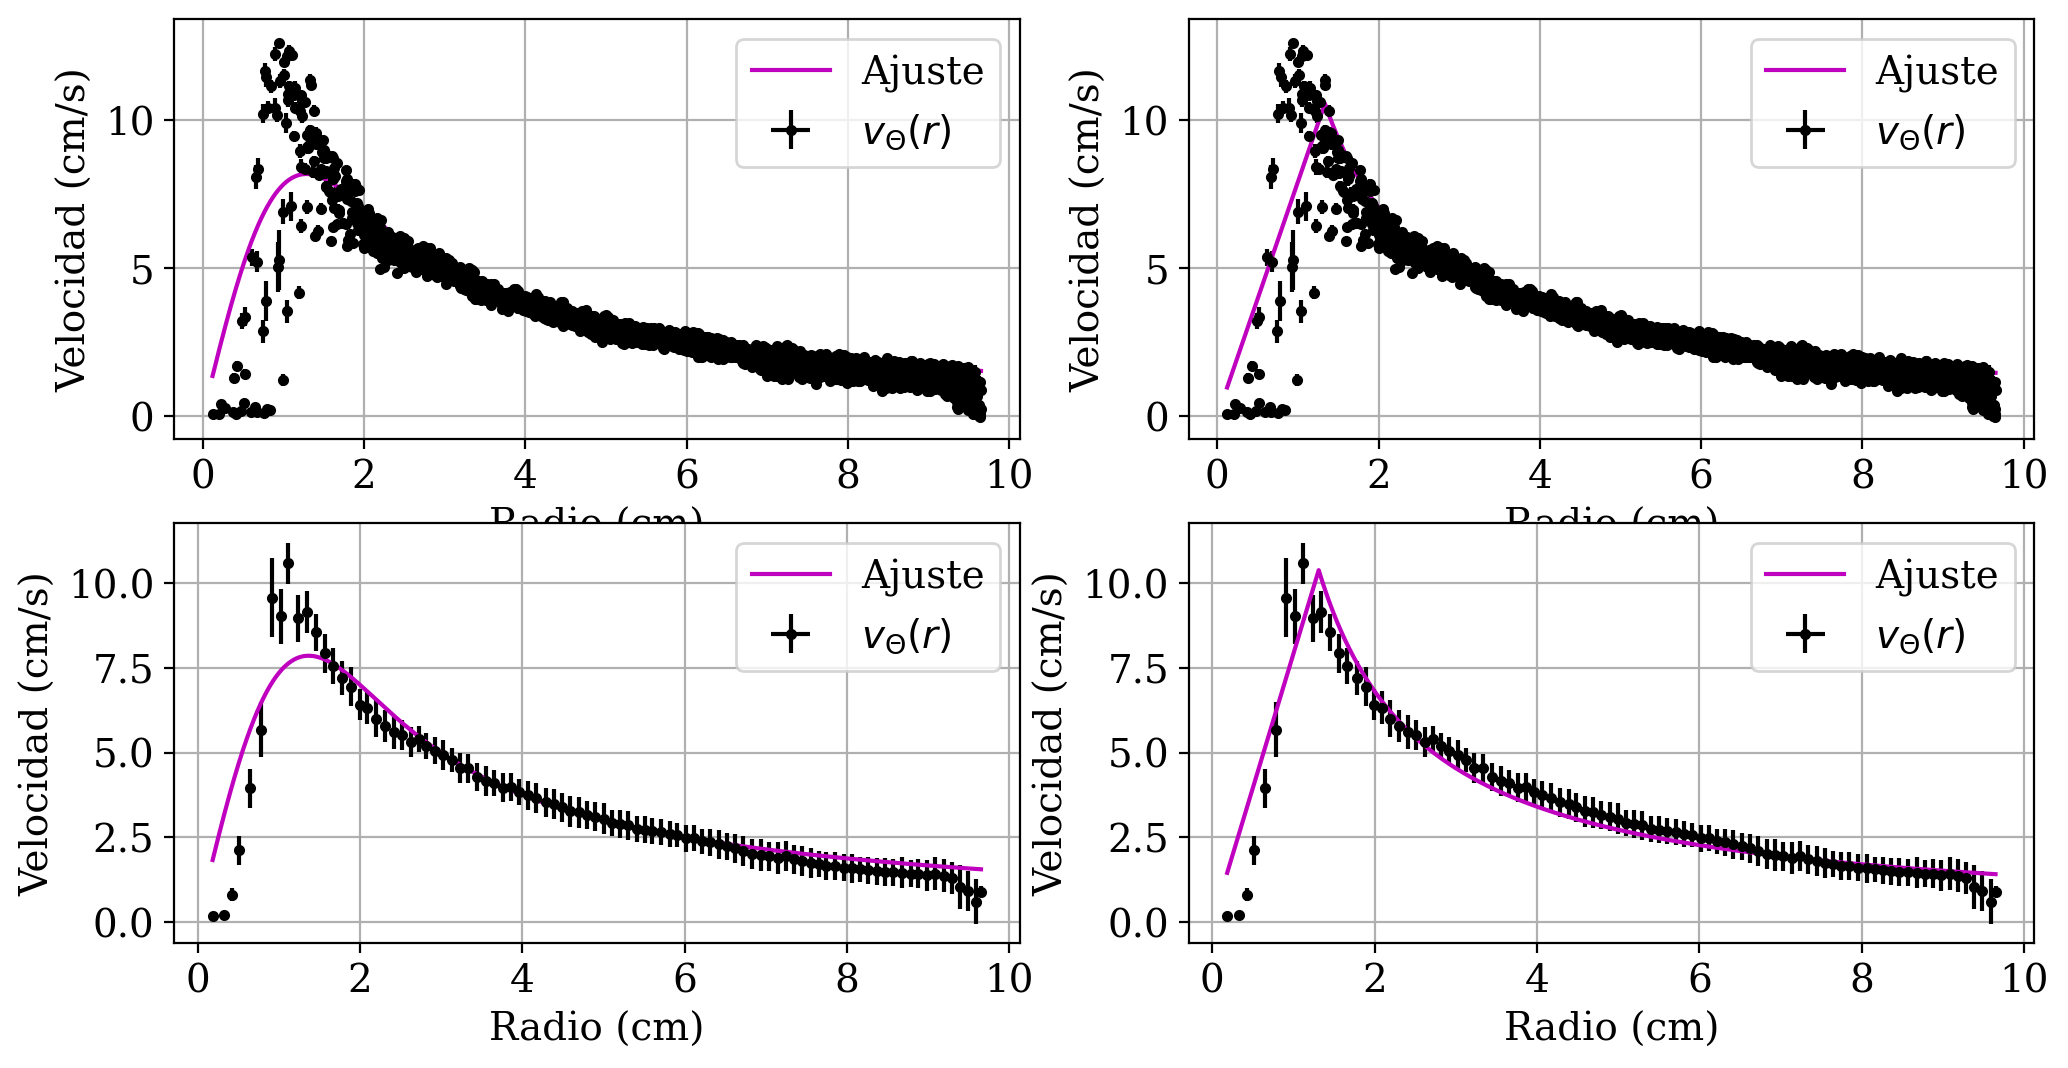

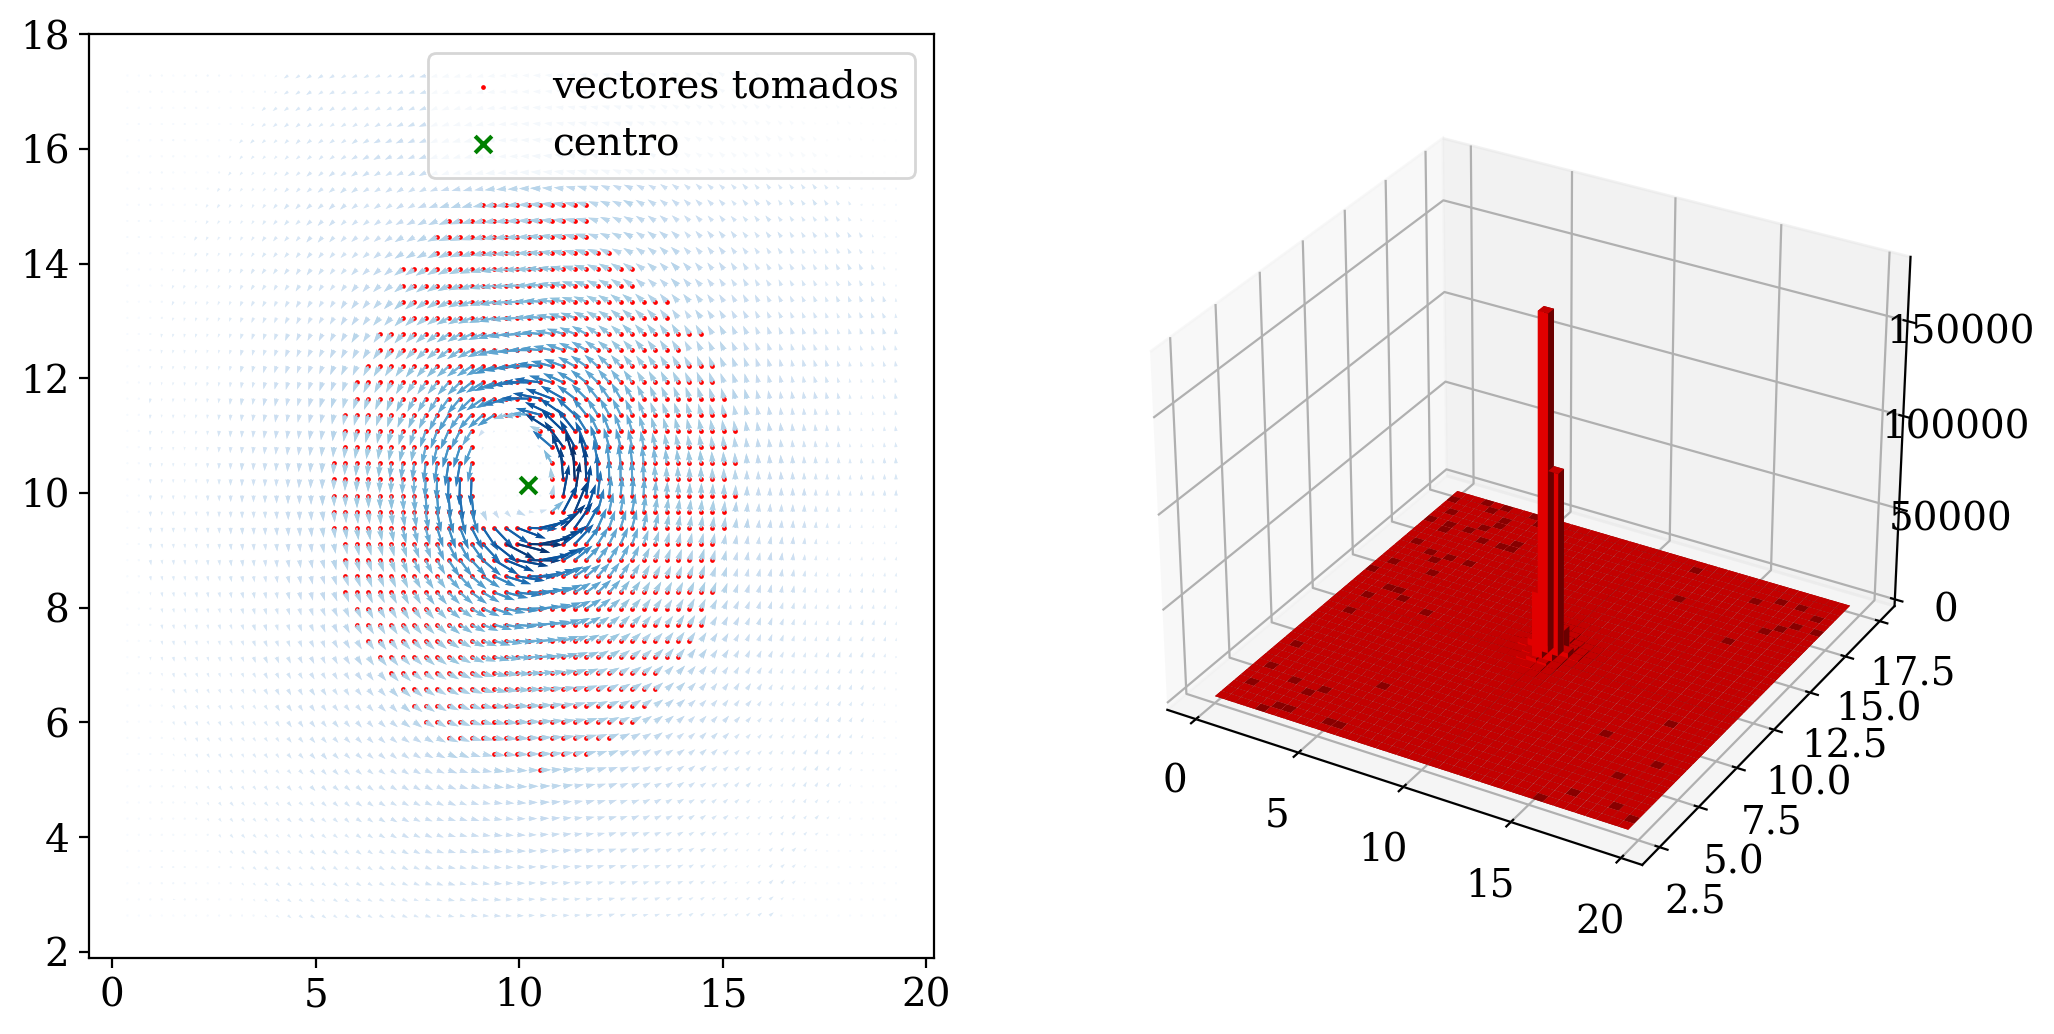

La velocidad angular Omega es 9.653 con error 0.707
El radio del vortice c es 1.476 con error 0.0498
La velocidad angular Omega es 7.396 con error 0.199
El radio del vortice c es 1.611 con error 0.0255
La velocidad angular Omega es 10.958 con error 0.234
El radio del vortice c es 1.366 con error 0.0141
La velocidad angular Omega es 7.601 con error 0.093
El radio del vortice c es 1.605 con error 0.0106


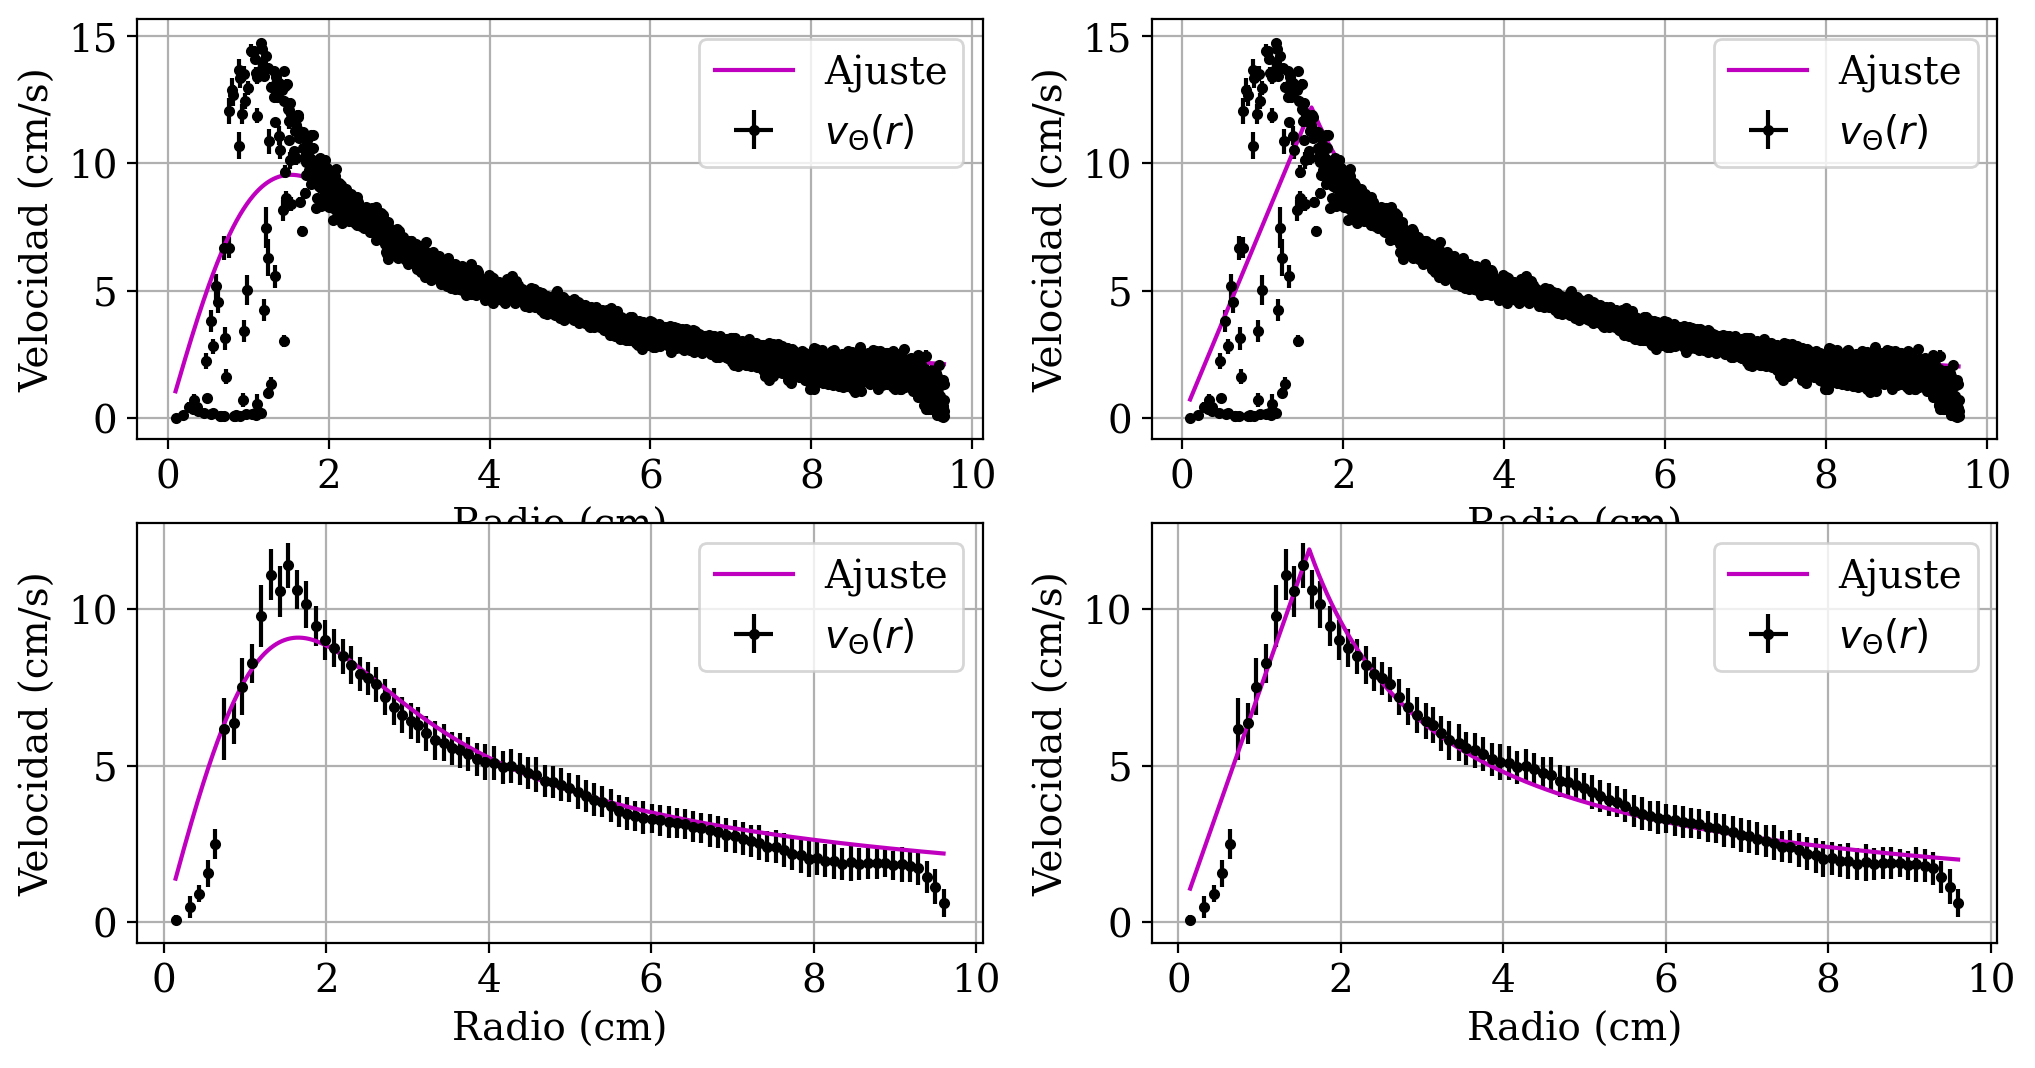

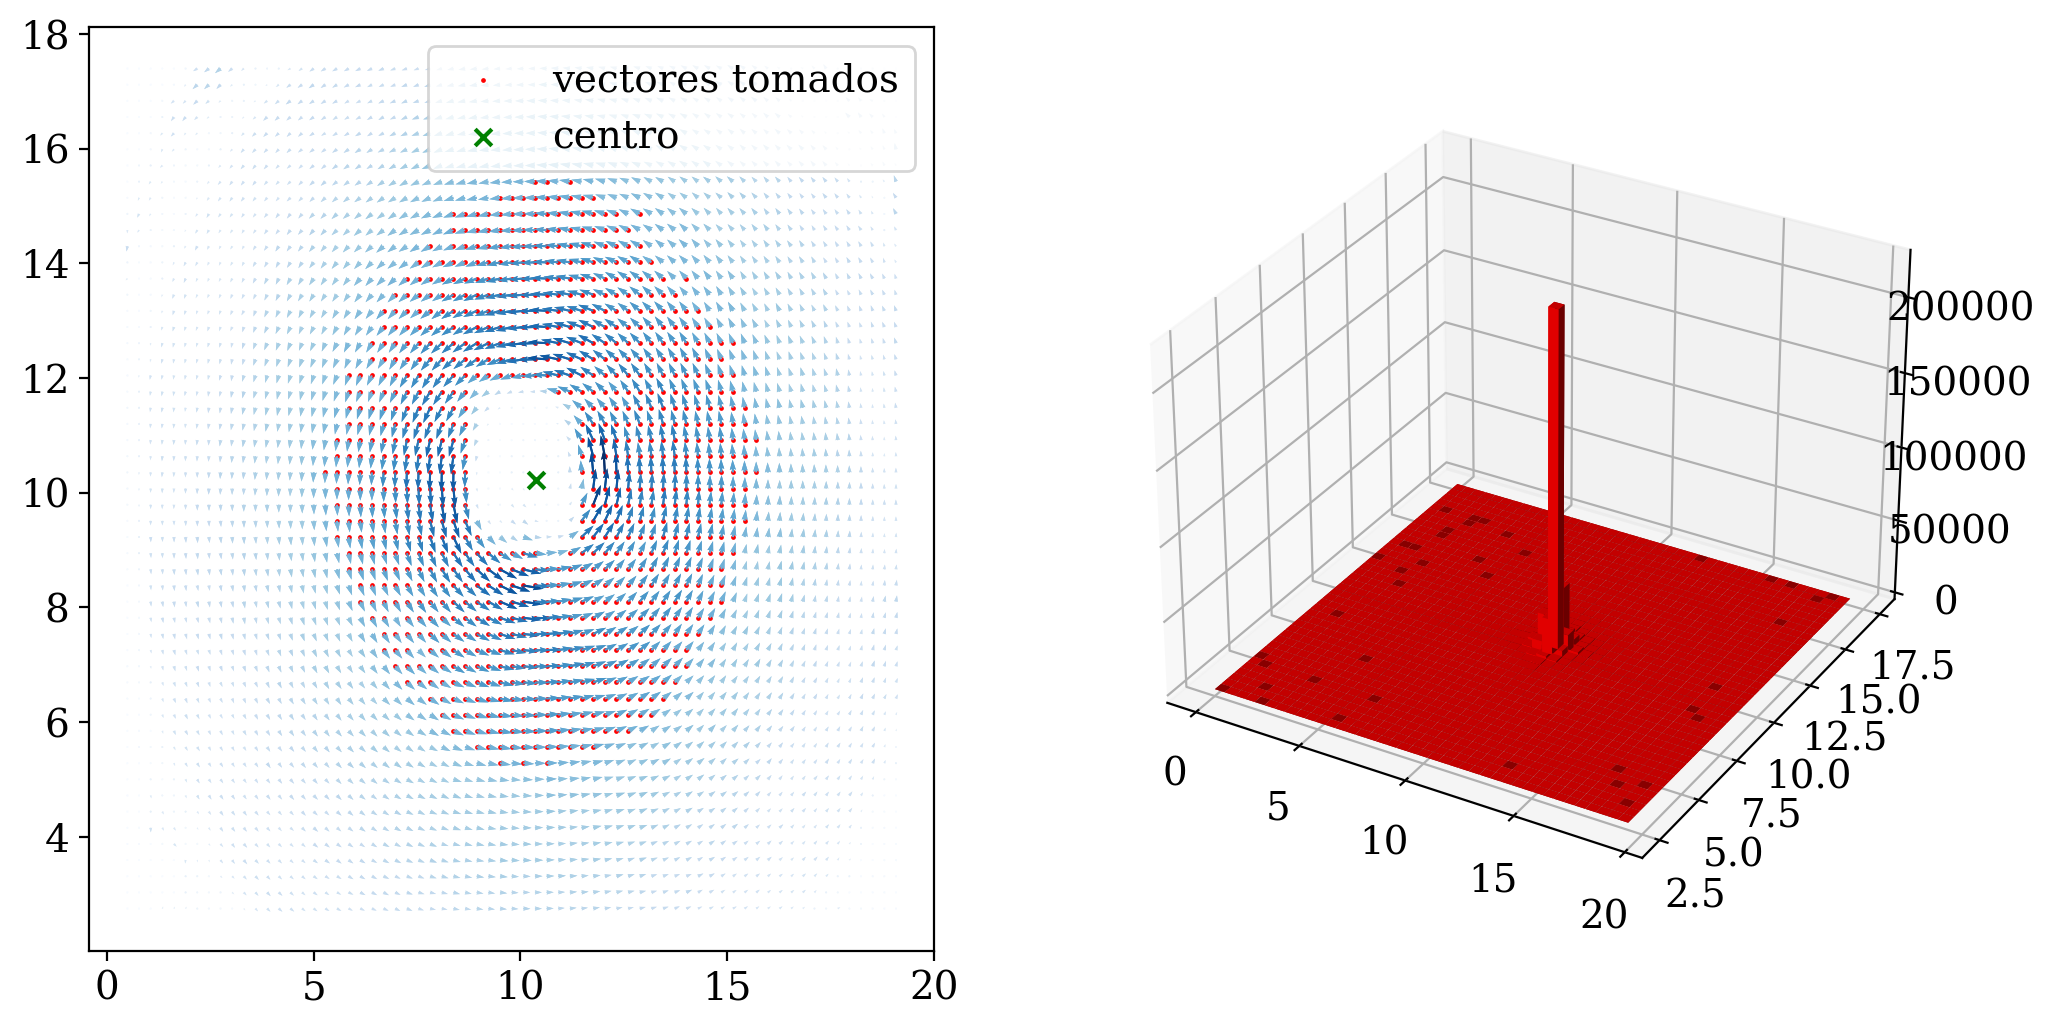

La velocidad angular Omega es 5.484 con error 0.427
El radio del vortice c es 2.499 con error 0.0879
La velocidad angular Omega es 4.082 con error 0.112
El radio del vortice c es 2.736 con error 0.0467
La velocidad angular Omega es 6.09 con error 0.097
El radio del vortice c es 2.323 con error 0.0174
La velocidad angular Omega es 4.098 con error 0.032
El radio del vortice c es 2.744 con error 0.0122


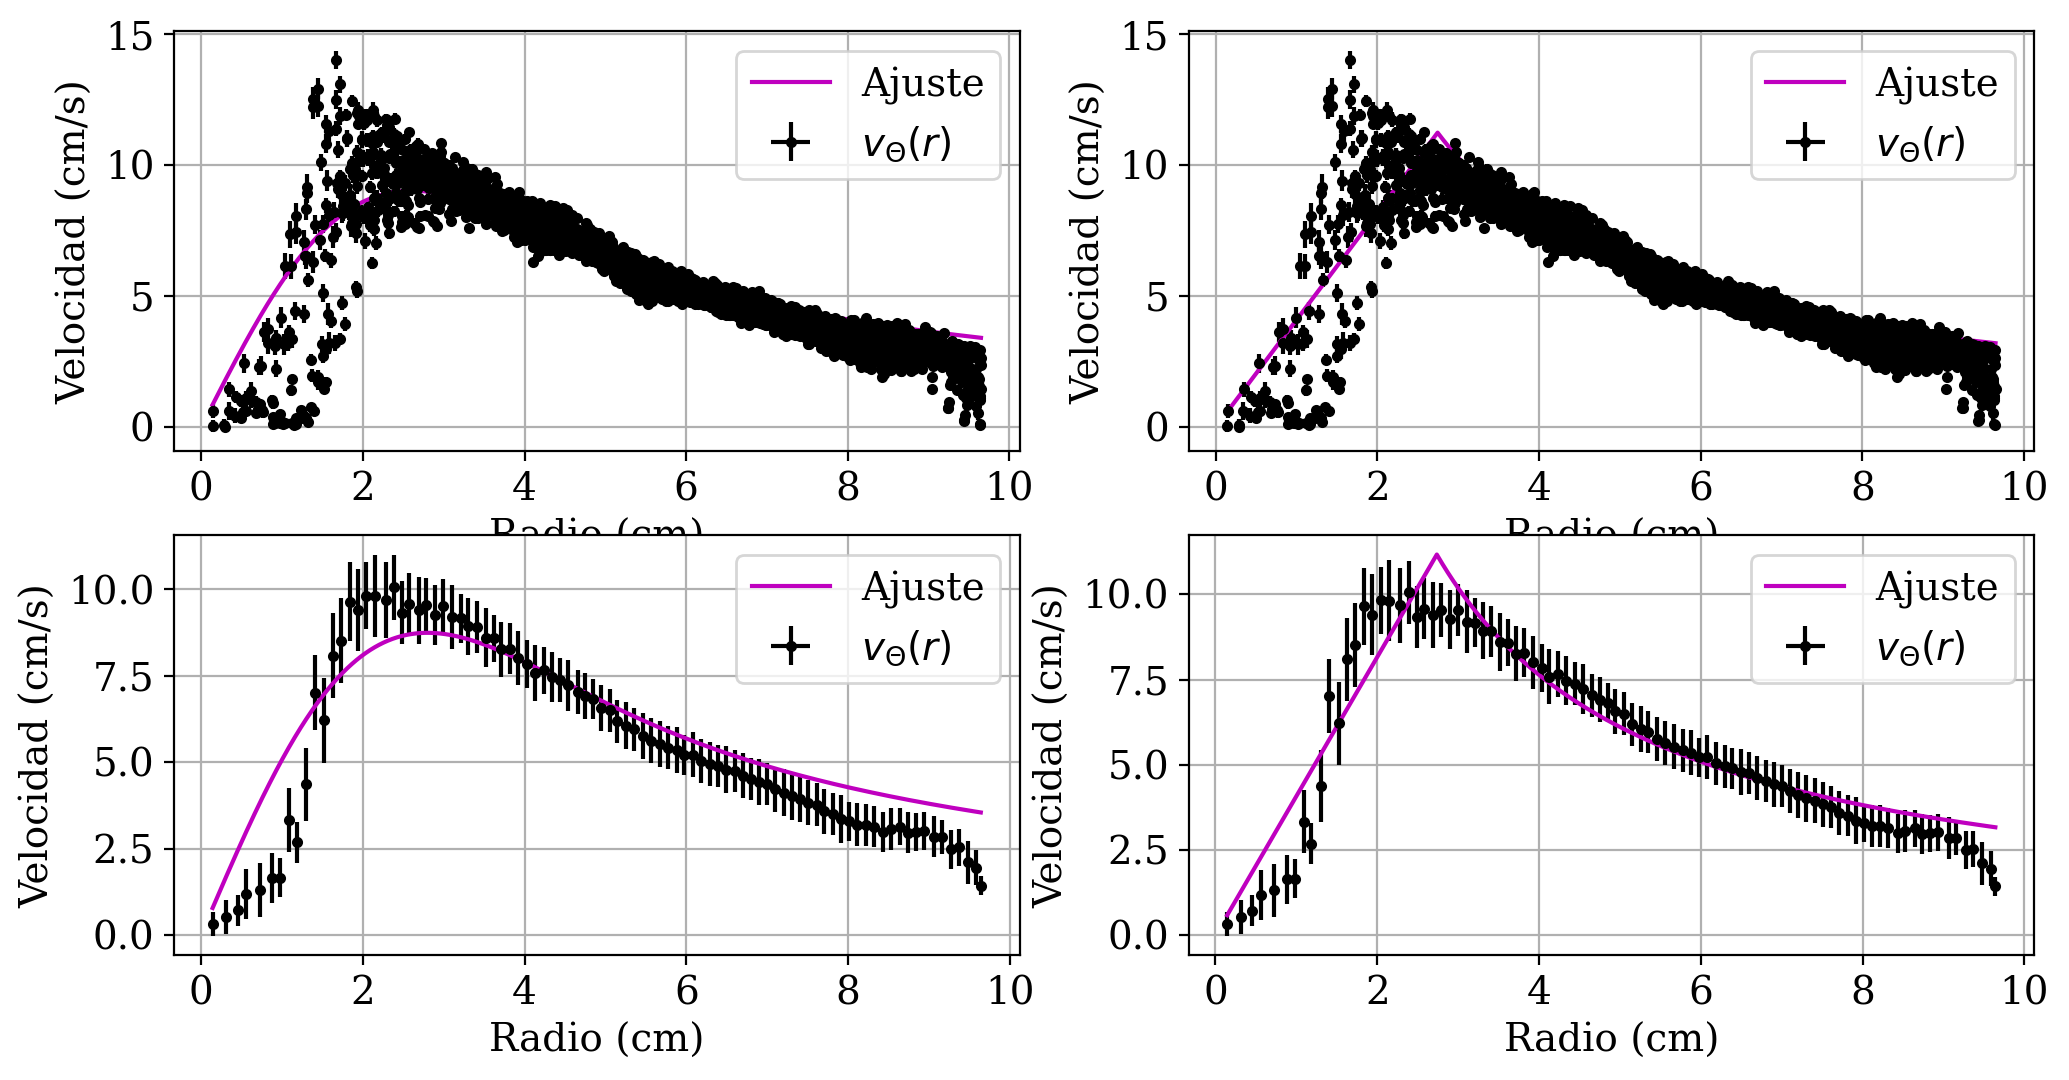

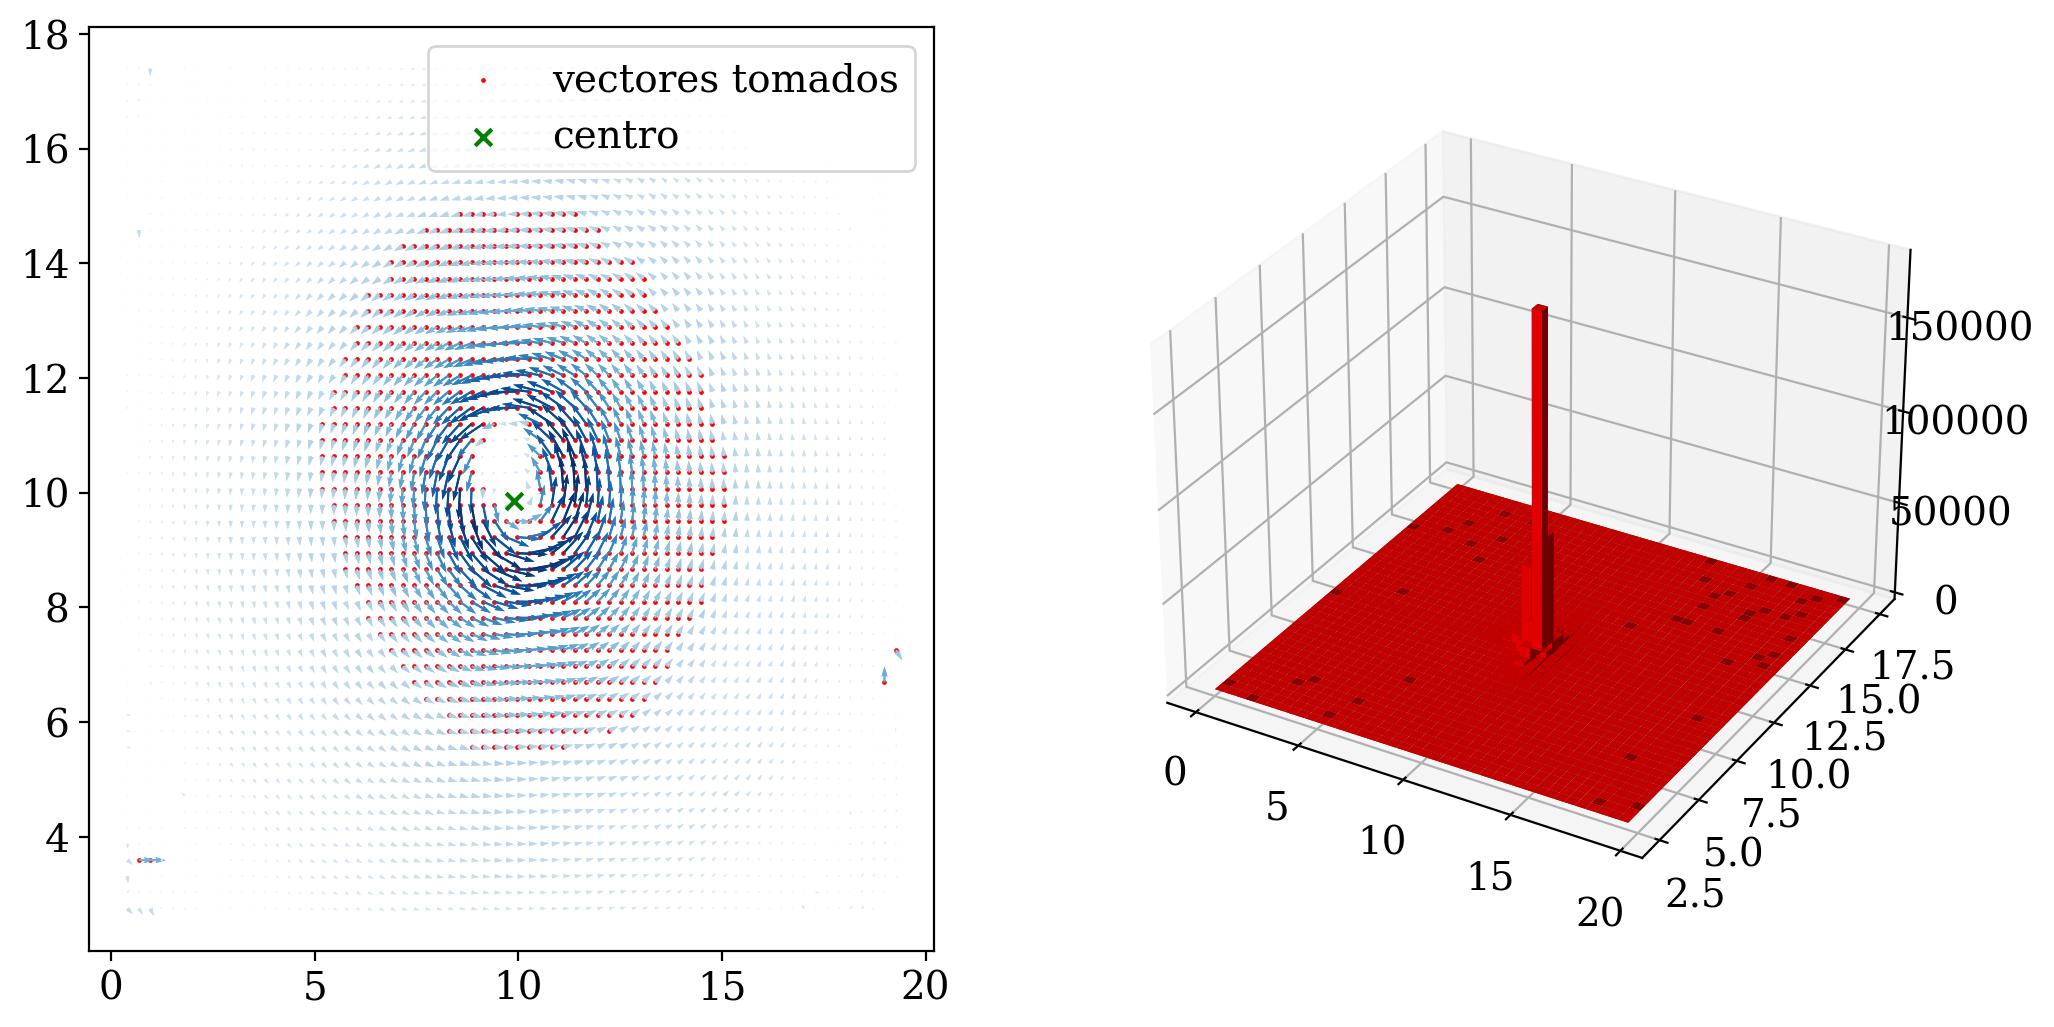

La velocidad angular Omega es 12.085 con error 0.656
El radio del vortice c es 1.298 con error 0.0326
La velocidad angular Omega es 7.976 con error 0.191
El radio del vortice c es 1.567 con error 0.0225
La velocidad angular Omega es 12.957 con error 0.237
El radio del vortice c es 1.234 con error 0.0109
La velocidad angular Omega es 7.874 con error 0.08
El radio del vortice c es 1.569 con error 0.0086


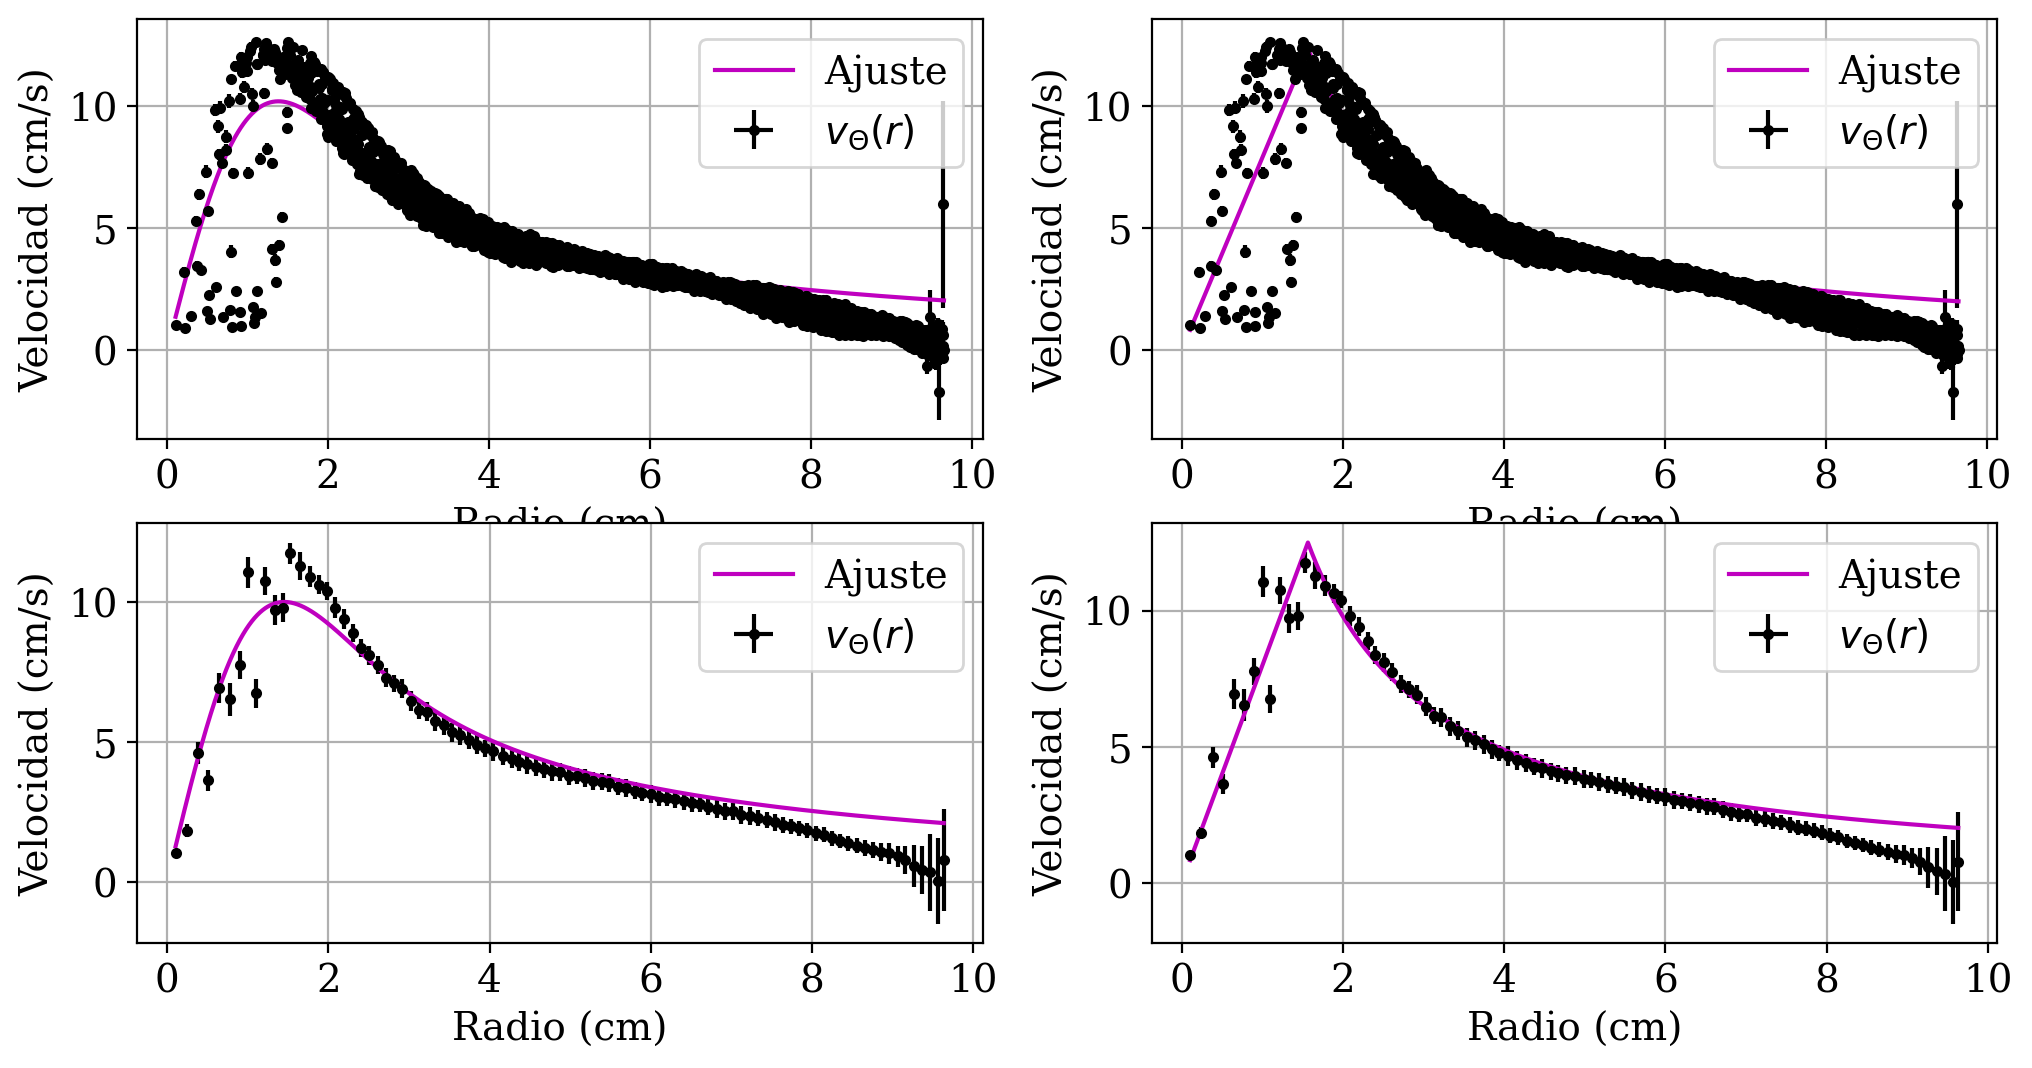

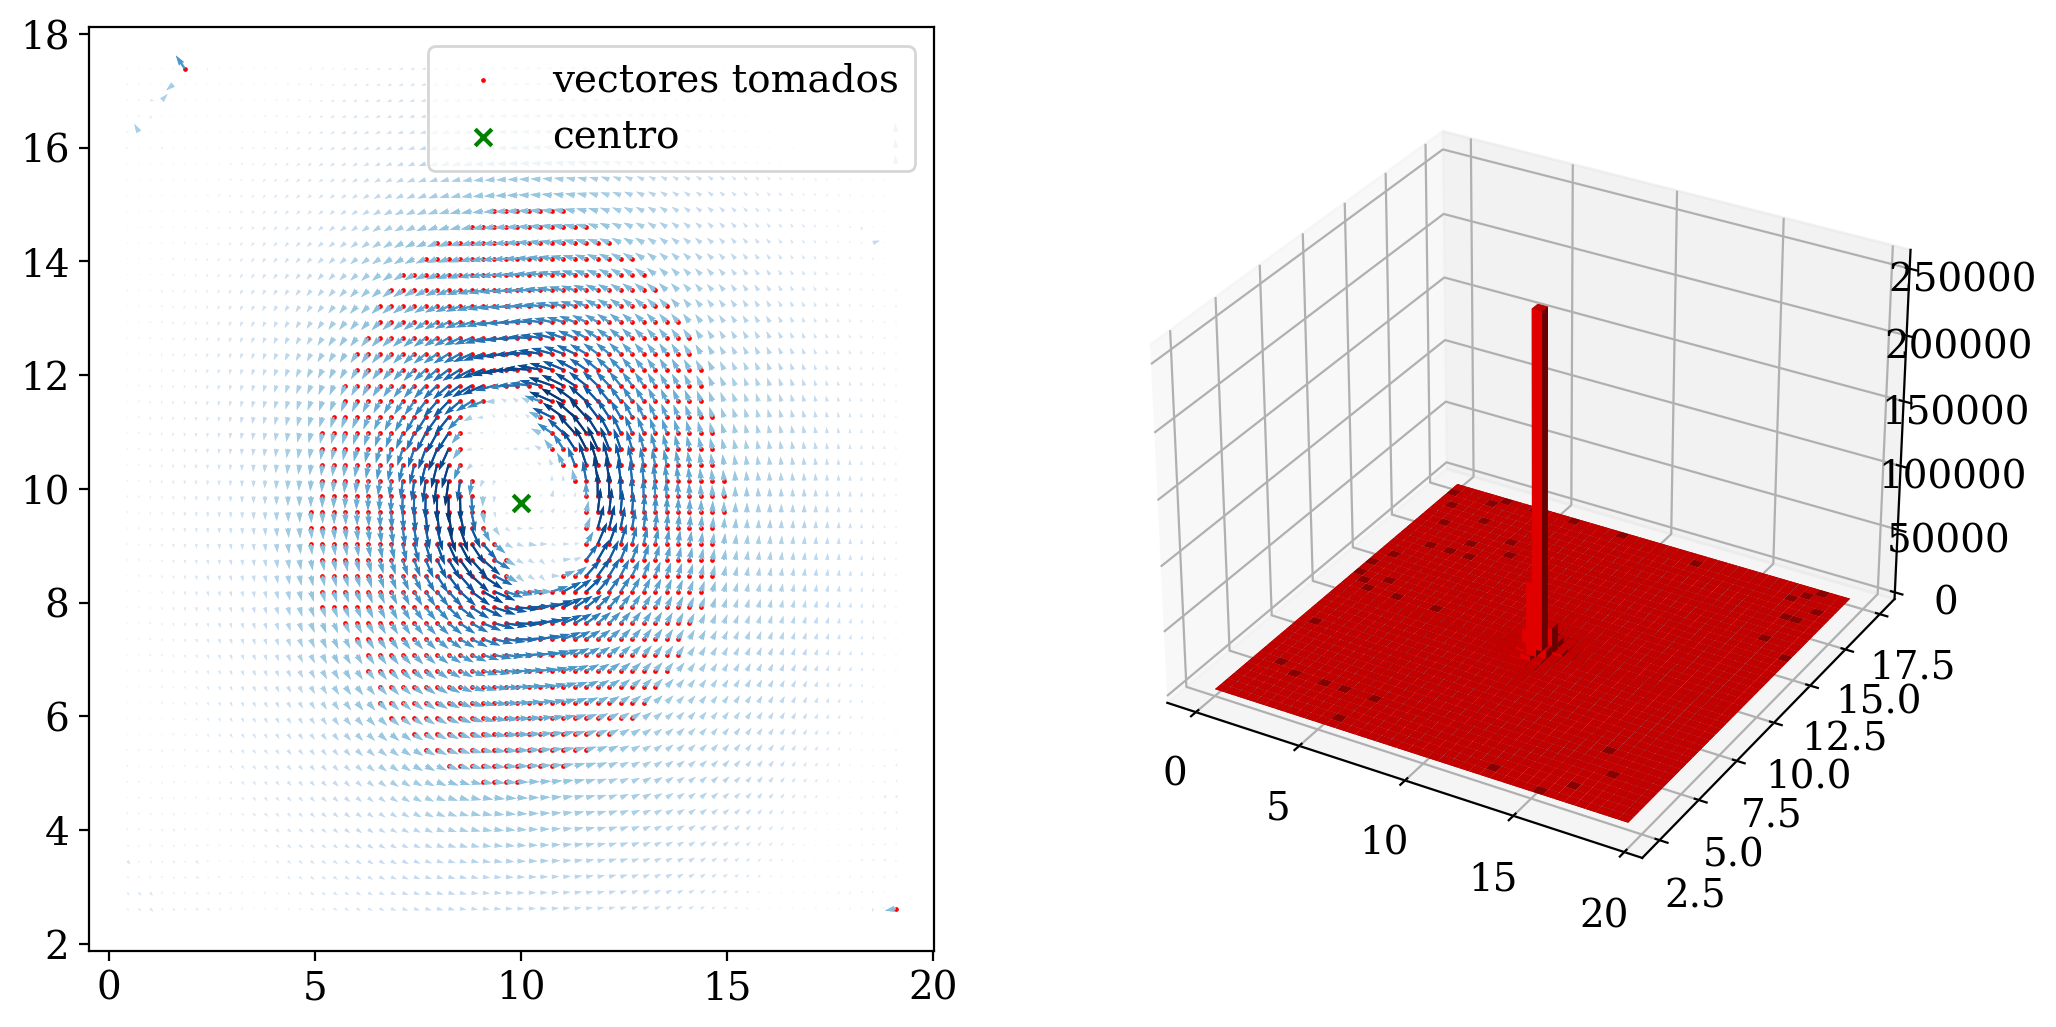

La velocidad angular Omega es 8.08 con error 0.762
El radio del vortice c es 2.108 con error 0.0906
La velocidad angular Omega es 6.0 con error 0.146
El radio del vortice c es 2.343 con error 0.0346
La velocidad angular Omega es 9.242 con error 0.19
El radio del vortice c es 1.922 con error 0.0188
La velocidad angular Omega es 6.167 con error 0.057
El radio del vortice c es 2.305 con error 0.0117


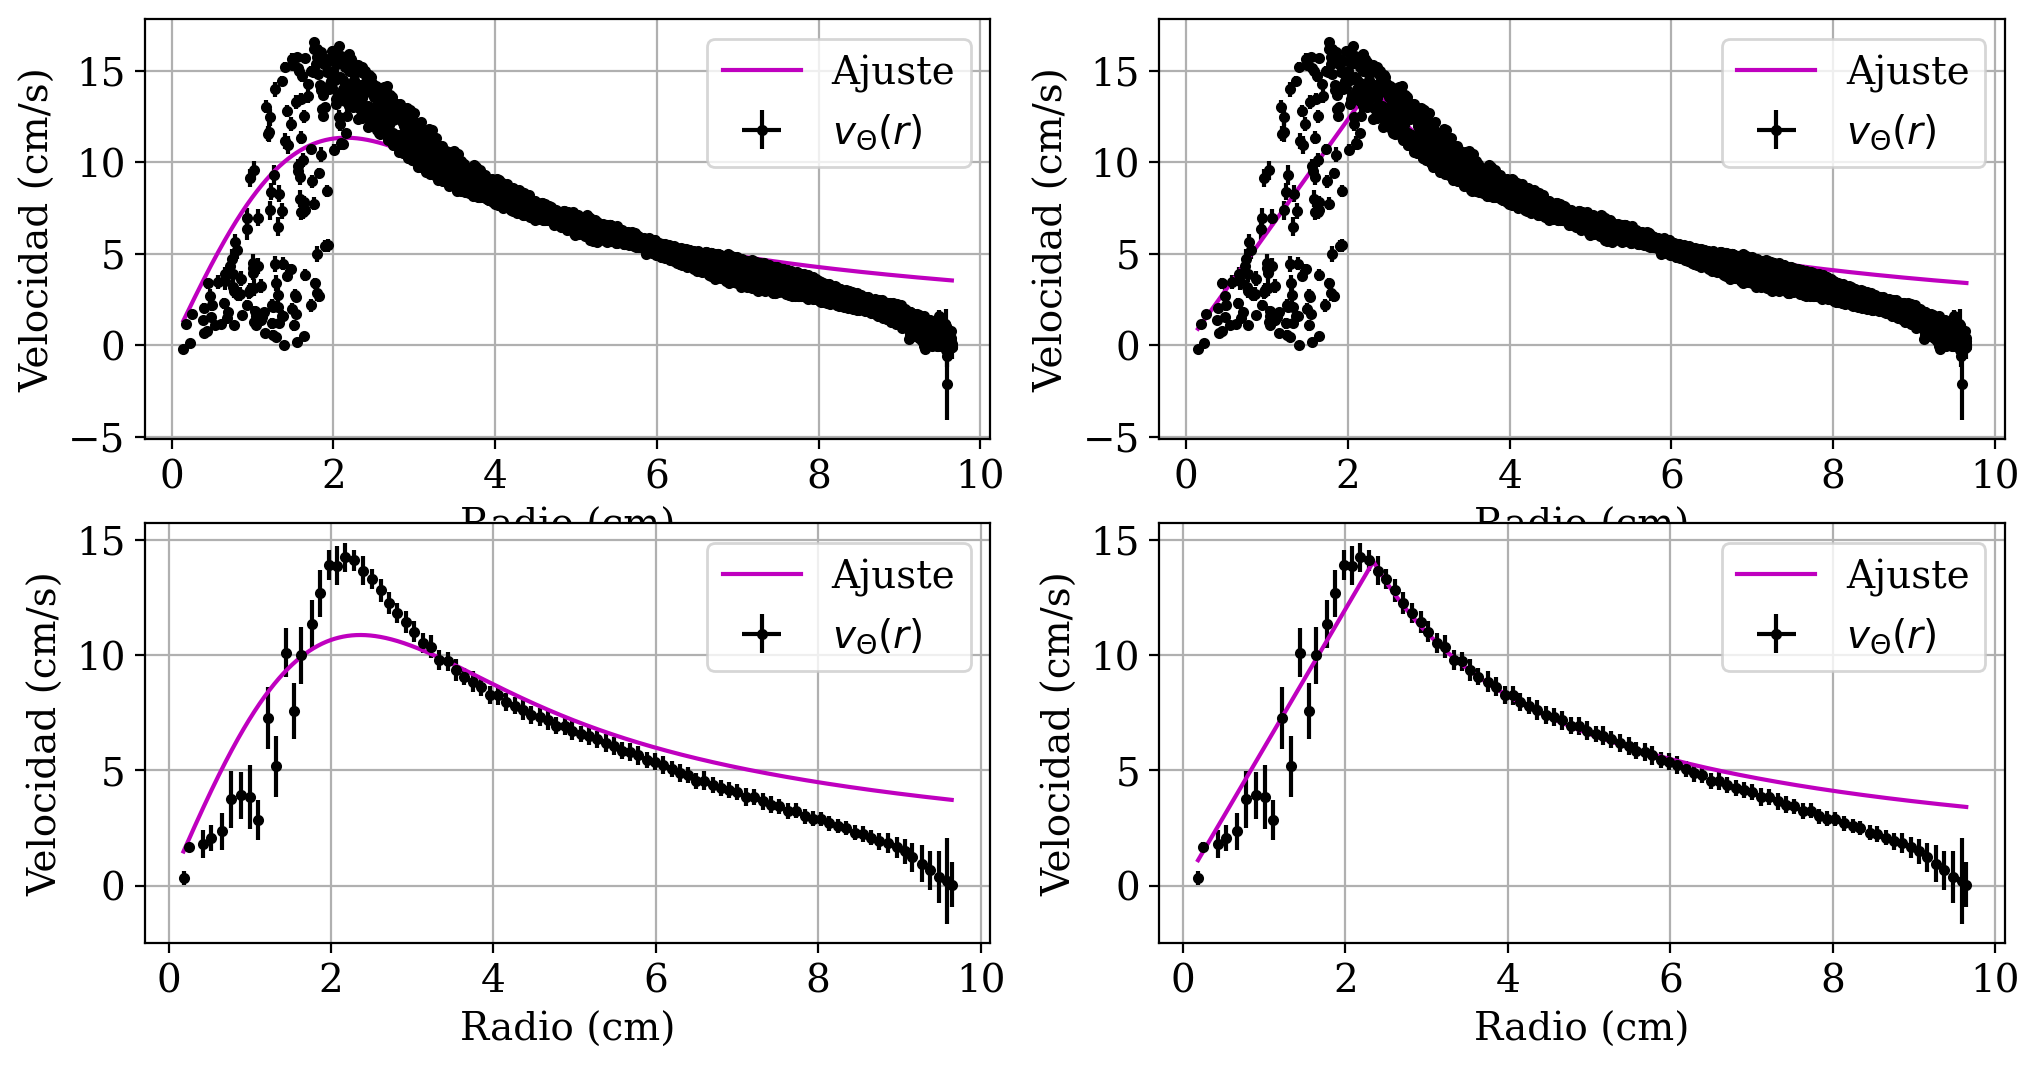

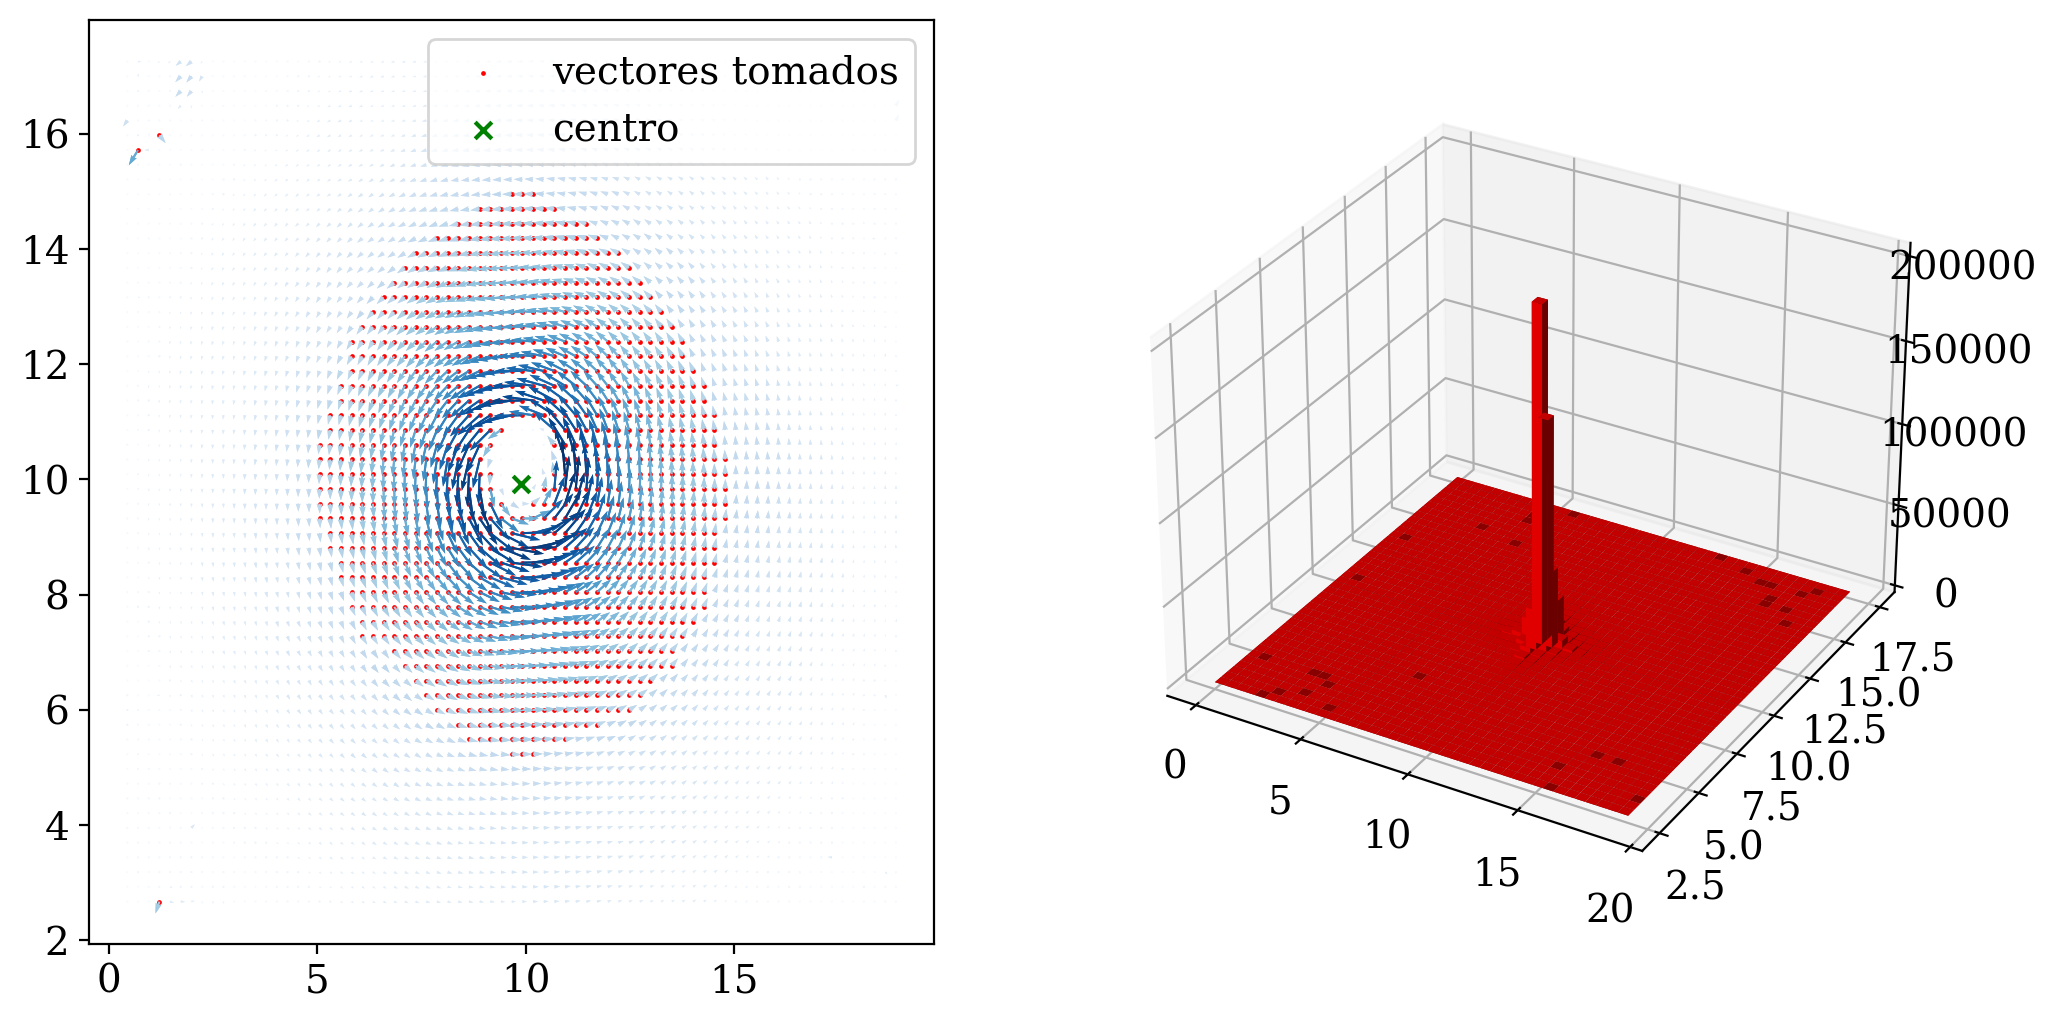

La velocidad angular Omega es 10.31 con error 0.929
El radio del vortice c es 1.296 con error 0.0538
La velocidad angular Omega es 7.458 con error 0.215
El radio del vortice c es 1.478 con error 0.0255
La velocidad angular Omega es 12.071 con error 0.231
El radio del vortice c es 1.159 con error 0.0107
La velocidad angular Omega es 7.759 con error 0.074
El radio del vortice c es 1.43 con error 0.0074


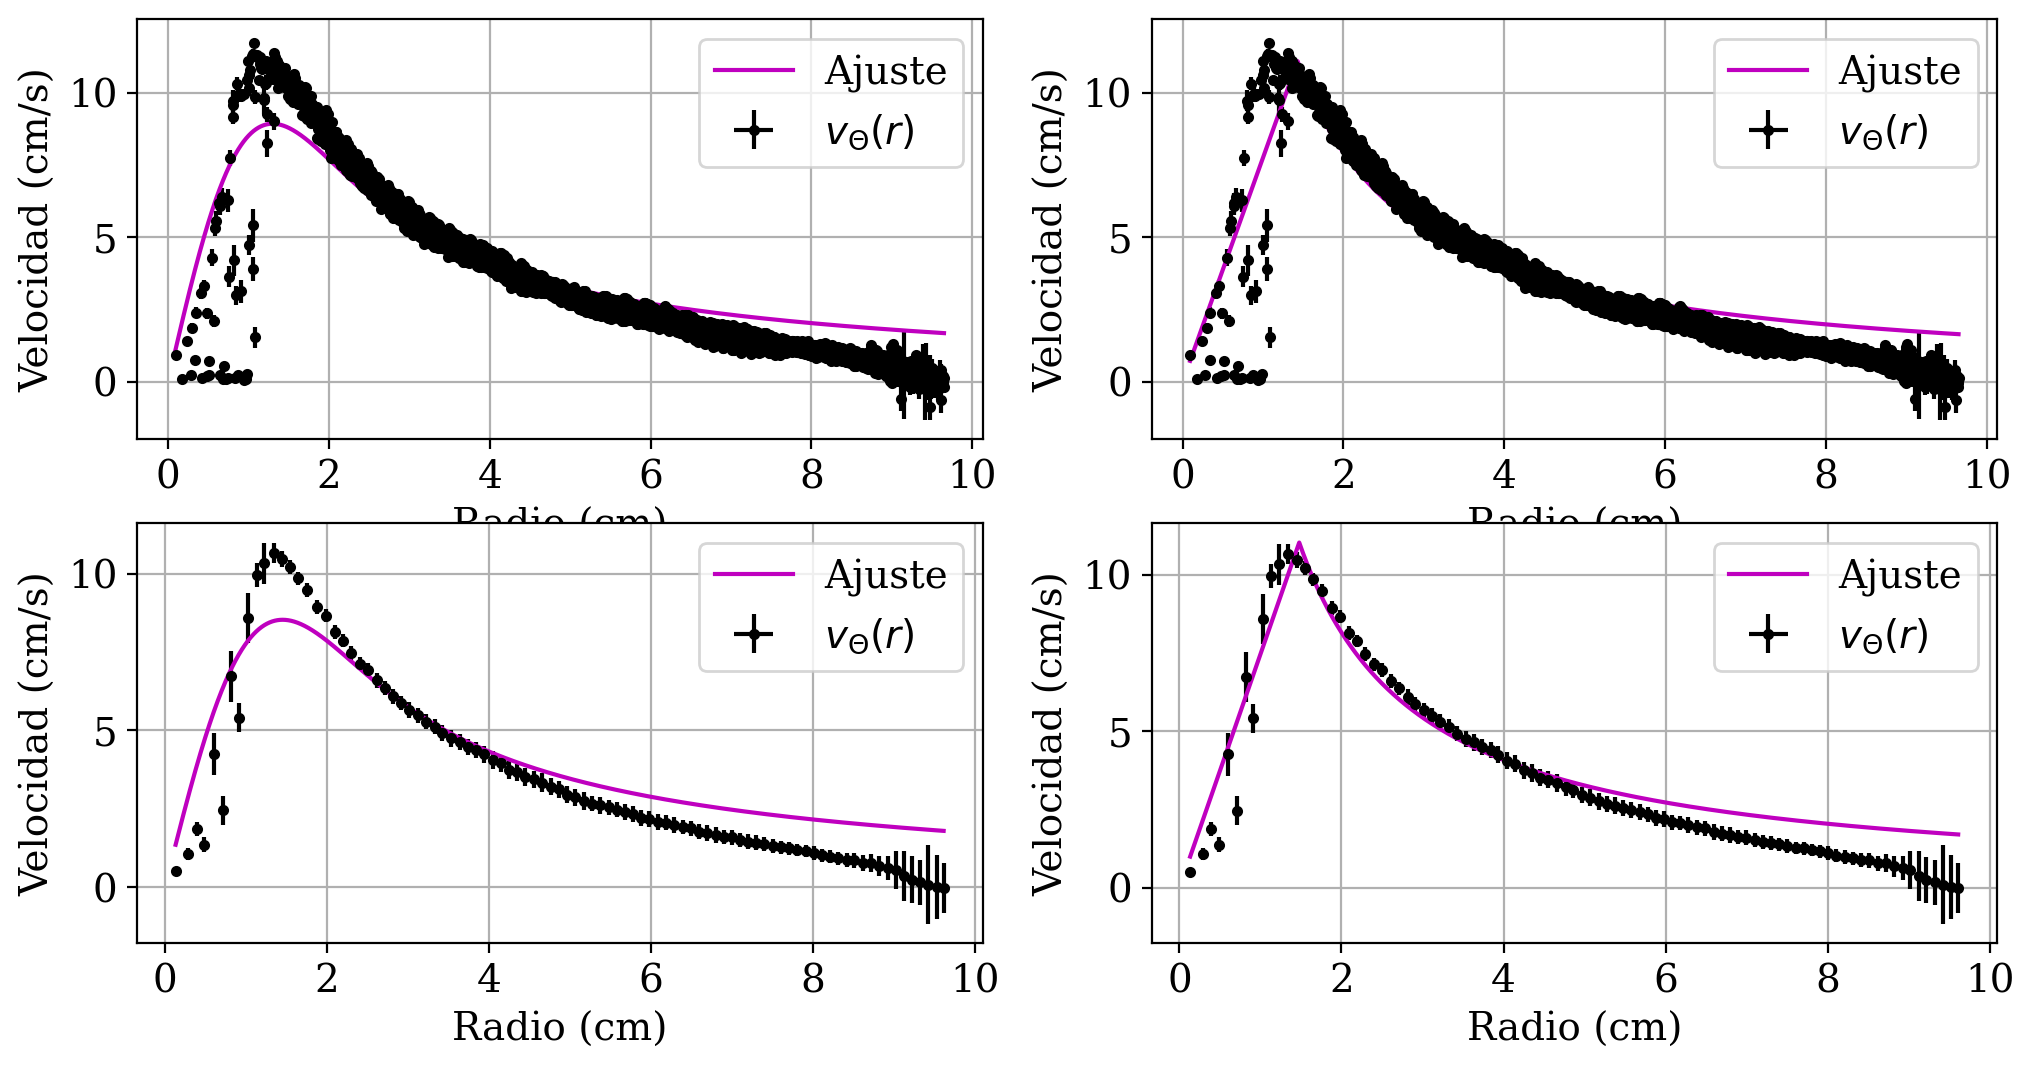

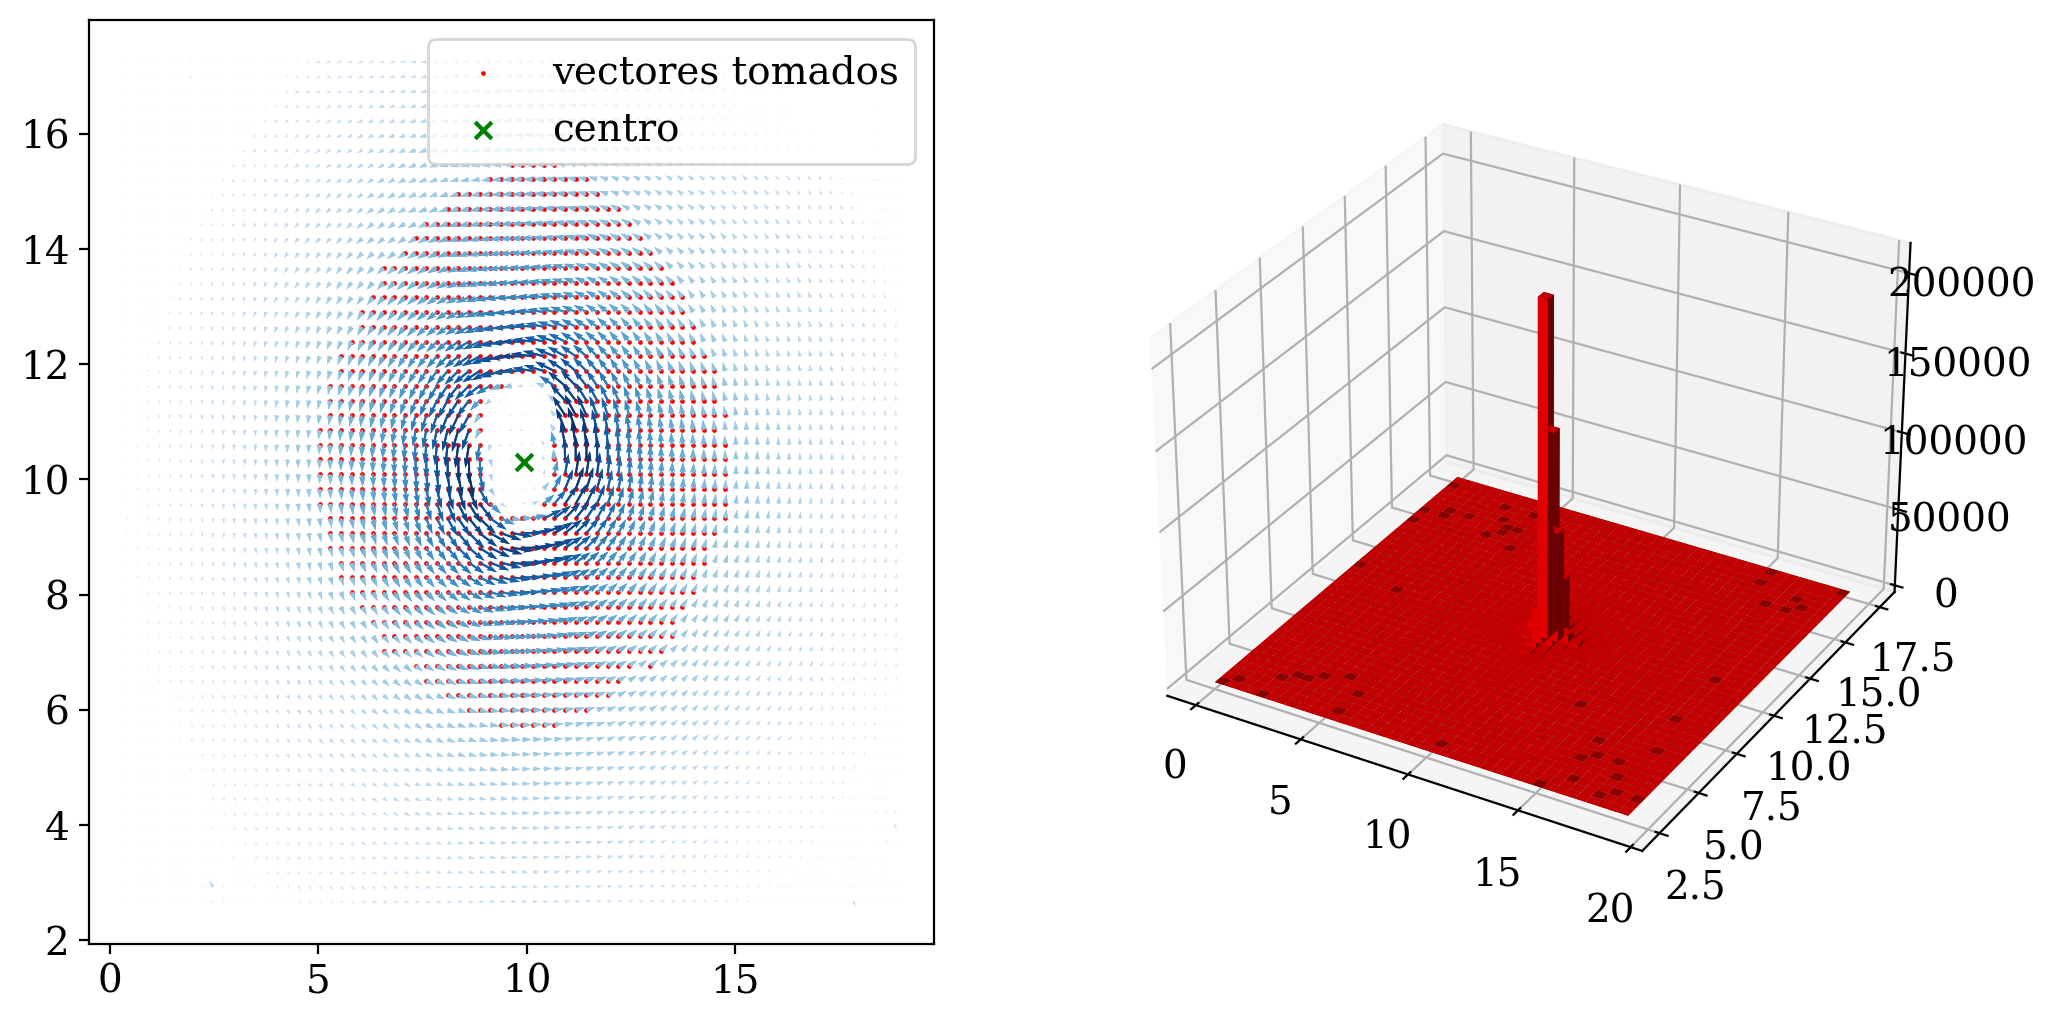

La velocidad angular Omega es 9.708 con error 0.732
El radio del vortice c es 1.701 con error 0.0589
La velocidad angular Omega es 7.287 con error 0.163
El radio del vortice c es 1.878 con error 0.0251
La velocidad angular Omega es 10.984 con error 0.16
El radio del vortice c es 1.571 con error 0.011
La velocidad angular Omega es 7.481 con error 0.054
El radio del vortice c es 1.863 con error 0.0073


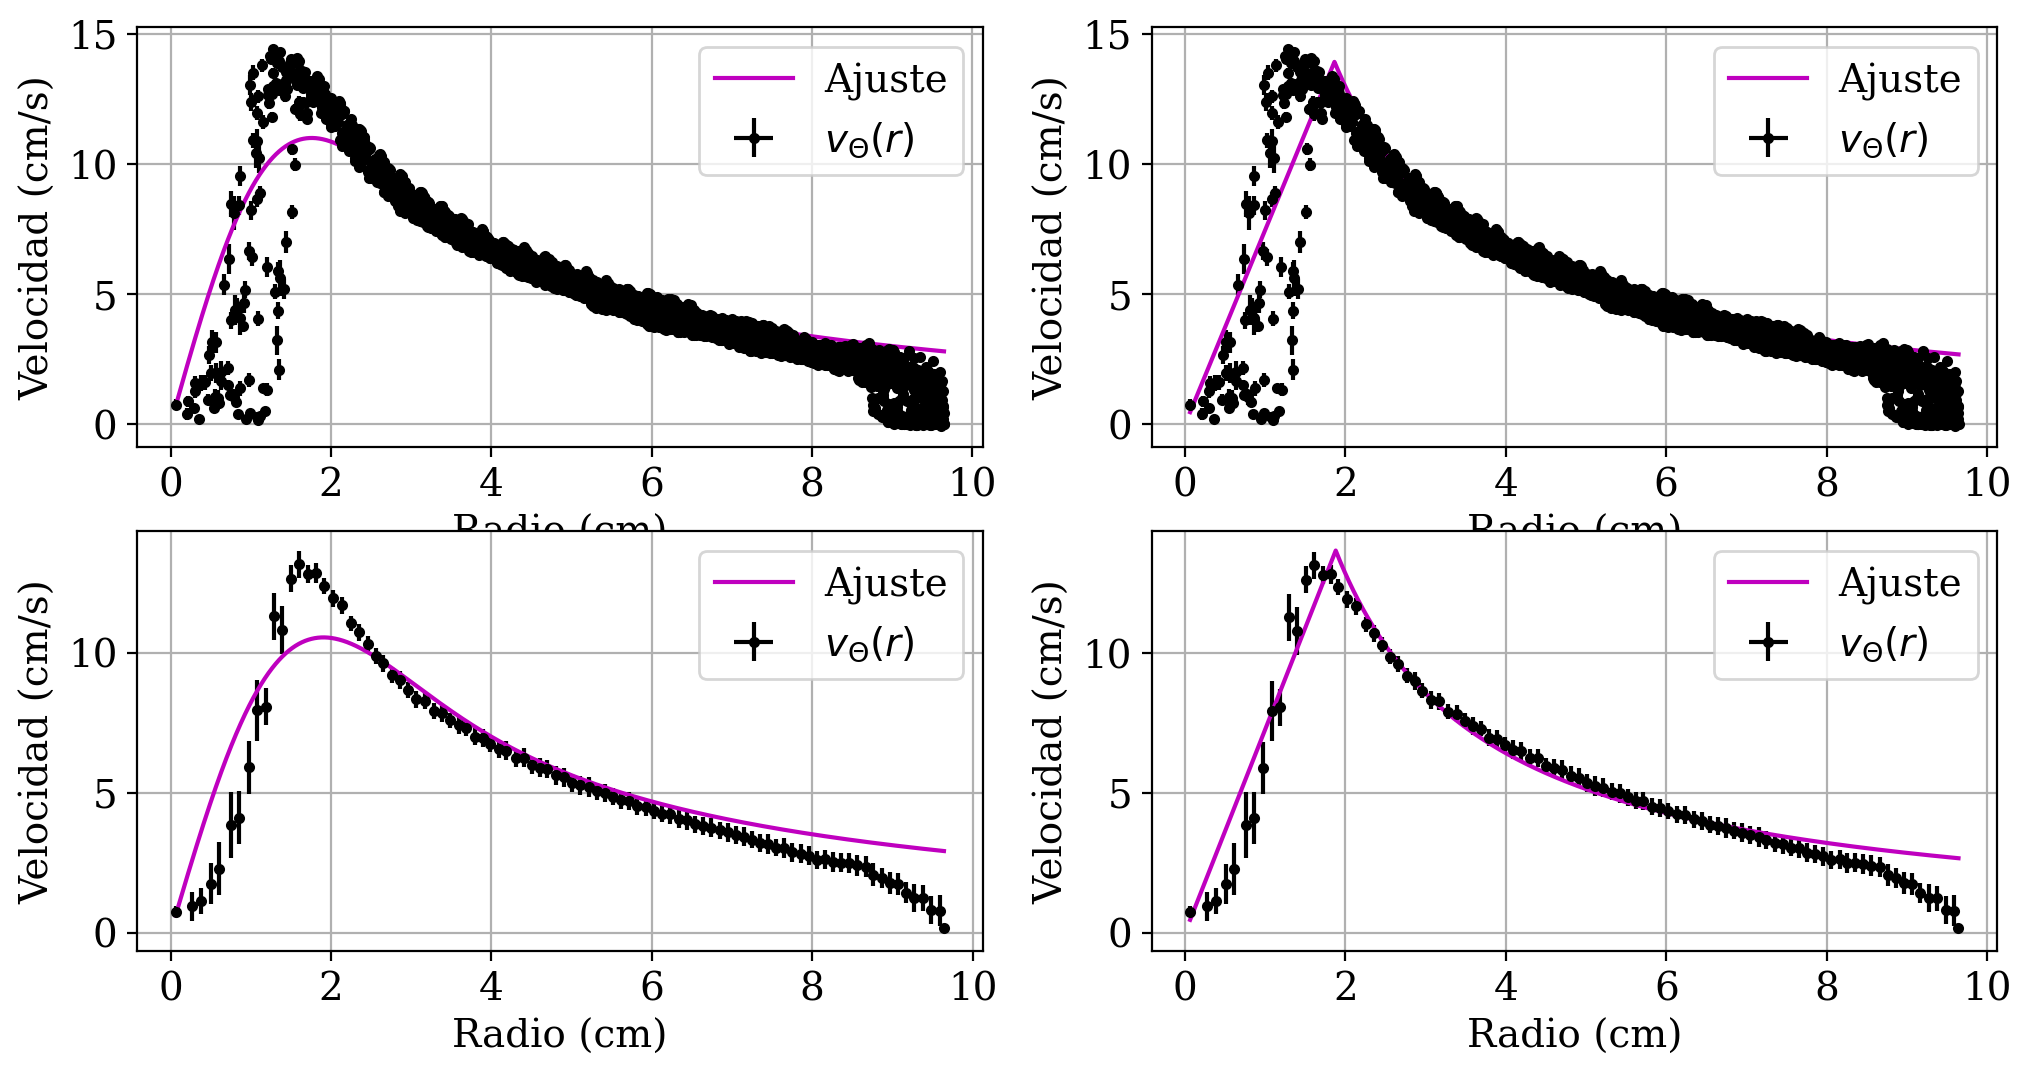

In [129]:
radio_recipiente = 9.65
dir = "nuevas mediciones"
path_list = ["destilada lento dos filtros/destilada lento.npz", 
             "destilada medio dos filtros/destilada medio.npz", 
             "destilada rapido dos filtros/destilada rapido.npz",
             "glicerina 50 lento dos filtros/glicerina 50 lento.npz",
             "glicerina 50 rapido dos filtros/glicerina 50 rapido.npz",
             "glicerina 25 lento dos filtros/glicerina 25 lento.npz",
             "glicerina 25 rapido dos filtros/glicerina 25 rapido.npz"
             ]
for i in range(len(path_list)):
    find_center(dir+"/"+path_list[i], r_max=radio_recipiente, fit_lims=[0.3, 7], y_lims=[2.5,17.5], v_quantile=.75, interval=0.1)

multiplicar funcion de ajuste por funcion sigmoide suave. tanh() por ej, exponencial por ahi.
estimar hasta donde no se aprecian efectos de borde.

opcion b. Ir variando el corte, y fijarse como varian los parametros.

Dividir errores por raiz de n.